***
# Model Building

I am to build a regression model to help future data scientists get their up-to-date salary estimate.

I will perform:

- Multiple linear regression

- Lasso regression

- Ridge regression

- Random forest regressor

to find out the best-performing model.

I would use __"negative mean absolute error"__ to score each model. Since I am trying to predict a numerical value, I think mean absolute error (MAE) would be the most direct score to compare.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import pickle

In [2]:
df = pd.read_csv("data-scientist-salary-eda.csv")

### Select and modify relevant columns

In [3]:
df_model = df[['avg_salary', "Rating", "Size", 'Type of ownership', 'Industry', 'Revenue', 'job_state', 'age', 'python_y/n', 'spark_y/n', 'aws_y/n', 'excel_y/n', 'sas_y/n', 'matlab_y/n', 'tableau_y/n', 'tensorflow_y/n', 'job_simplified', 'seniority', "description_length"]]

### Convert categorical variables to dummy variables

In [4]:
df_dum = pd.get_dummies(df_model)

In [5]:
# replace "-1" in rating column with the average of rating
df_dum["Rating"].replace(-1.0, np.mean(df_dum["Rating"]), inplace= True)

In [6]:
# replace "-1" in age column with the average of age
df_dum["age"].replace(-1, np.mean(df_dum["age"]), inplace= True)

### Split train and test data sets

In [7]:
X = df_dum.drop("avg_salary", axis= 1)
y = df_dum["avg_salary"].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Multiple linear model

In [9]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [10]:
np.mean(cross_val_score(lm, X_train, y_train, scoring= "neg_mean_absolute_error"))

-23.922701323066228

### Lasso

In [11]:
lm_l = Lasso()
lm_l.fit(X_train, y_train)
np.mean(cross_val_score(lm_l, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 10))

-21.897947574524572

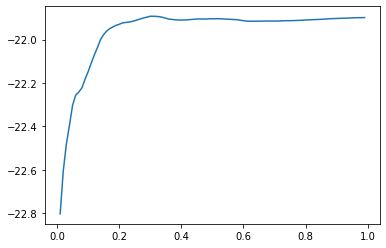

In [12]:
# Use a for loop to find the optimal alpha value

lasso_alpha= []
lasso_error= []

for i in range(1,100):
    lasso_alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    lasso_error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 10)))

plt.plot(lasso_alpha, lasso_error)

In [30]:
lasso_err = list(zip(lasso_alpha, lasso_error))
lasso_err_df = pd.DataFrame(lasso_err, columns=["alpha", "error"])
lasso_err_df[lasso_err_df["error"] == lasso_err_df.error.max()]

,alpha,error
29,0.3,-21.892004


In [31]:
# Modify the lasso classifier with the optimal alpha
lm_l = Lasso(0.3)
lm_l.fit(X_train, y_train)

Lasso(alpha=0.3)

### Ridge regression

In [15]:
lm_rid = Ridge()
lm_rid.fit(X_train, y_train)
np.mean(cross_val_score(lm_l, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 10))

-21.897092978792376

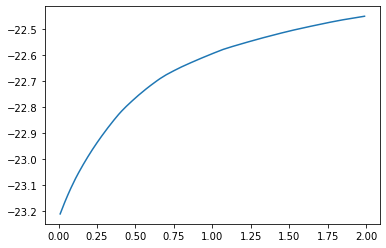

In [16]:
# Use a for loop to find the optimal alpha value
ridge_alpha = []
ridge_error = []

for i in range(1,200):
    ridge_alpha.append(i/100)
    lmrid = Ridge(i/100)
    ridge_error.append(np.mean(cross_val_score(lmrid, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 10)))

plt.plot(ridge_alpha, ridge_error)

In [17]:
ridge_err = list(zip(ridge_alpha, ridge_error))
ridge_err_df = pd.DataFrame(ridge_err, columns=["alpha", "error"])
ridge_err_df[ridge_err_df["error"] == ridge_err_df.error.max()]

,alpha,error
198,1.99,-22.449288


In [18]:
# Modify the ridge classifier with the optimal alpha
lm_rid = Ridge(alpha= 1.99)
lm_rid.fit(X_train, y_train)

Ridge(alpha=1.99)

### Random forest regressor

In [19]:
rf = RandomForestRegressor()
cross_val_score(rf, X_train, y_train, scoring= "neg_mean_absolute_error", cv= 10)

array([-22.59745218, -22.68931432, -22.79800017, -23.86024178,
       -23.56734636, -22.66663076, -19.96379468, -24.138568  ,
       -24.4323657 , -24.56125818])

In [20]:
# Use RandomizedSearchCV to find the optimal parameters
parameters = {'n_estimators':range(10,300,10),
              'criterion':('mse', 'mae'),
              'max_features':('auto', 'sqrt', 'log2')}

In [21]:
gs = RandomizedSearchCV(rf, parameters, scoring= "neg_mean_absolute_error", cv=10)

In [22]:
gs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ('mse', 'mae'),
                                        'max_features': ('auto', 'sqrt',
                                                         'log2'),
                                        'n_estimators': range(10, 300, 10)},
                   scoring='neg_mean_absolute_error')

In [23]:
gs.best_score_

-22.376648437500002

In [24]:
gs.best_estimator_

RandomForestRegressor(criterion='mae', max_features='log2', n_estimators=200)

### Test the performance of each model

In [36]:
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_ridml = lm_rid.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

In [37]:
print("Multiple linear regression MAE: ", mean_absolute_error(y_test, tpred_lm))
print("Lasso regression MAE: ", mean_absolute_error(y_test, tpred_lml))
print("Ridge regression MAE: ", mean_absolute_error(y_test, tpred_ridml))
print("Random forest regressor MAE: ", mean_absolute_error(y_test, tpred_rf))

Multiple linear regression MAE:  21.759900893859566
Lasso regression MAE:  22.287458153396003
Ridge regression MAE:  21.971370411902388
Random forest regressor MAE:  16.6944625


### Save the model

In [28]:
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )